In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


### predict the accuracy of Zestimate - Zillow Real Estate home pricing.<br>
Modeling of the data is done in the following step -- we do a quick exploratory analysis of the target value ( errors ), create new features, develop a simple xgboost model and analyze the importance of the features <br>
The features created include those from online public kernels and custom features

In [2]:
import operator
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error
import seaborn as sns


/Users/trasamsetti/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
### Data from Kaggle

In [4]:
properties = pd.read_csv('/Users/trasamsetti/Documents/other/Zillow/inp/properties_2016.csv')
train = pd.read_csv("/Users/trasamsetti/Documents/other/Zillow/inp/train_2016_v2.csv")



/Users/trasamsetti/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(properties.shape)
print(train.shape)

(2985217, 58)
(90275, 3)


In [6]:
properties = properties.rename(columns = {'calculatedfinishedsquarefeet':'cal_fin_sqft'})
properties = properties.rename(columns = {'structuretaxvaluedollarcnt':'struc_TVDC'})
properties = properties.rename(columns = {'taxvaluedollarcnt':'TVDC'})
properties = properties.rename(columns = {'landtaxvaluedollarcnt':'land_TVDC'})
properties = properties.rename(columns = {'finishedsquarefeet15':'fin_sqft15'})
properties = properties.rename(columns = {'finishedsquarefeet12':'fin_sqft12'})
properties = properties.rename(columns = {'finishedsquarefeet6':'fin_sqft6'})

#### Exploring data
##### looking at the target value

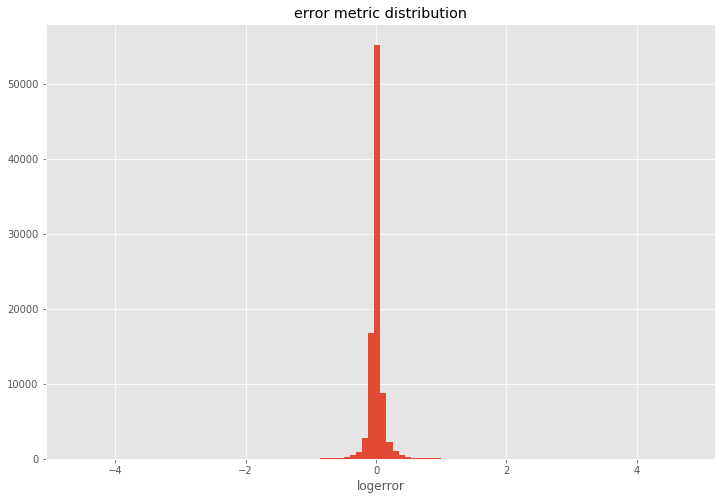

In [9]:
plt.figure(figsize=(12,8))
plt.hist(train.logerror.values, bins=100)
plt.title('error metric distribution')
plt.xlabel('logerror', fontsize=12)
plt.style.use('ggplot')
plt.show()

#### visualizing the location of properties

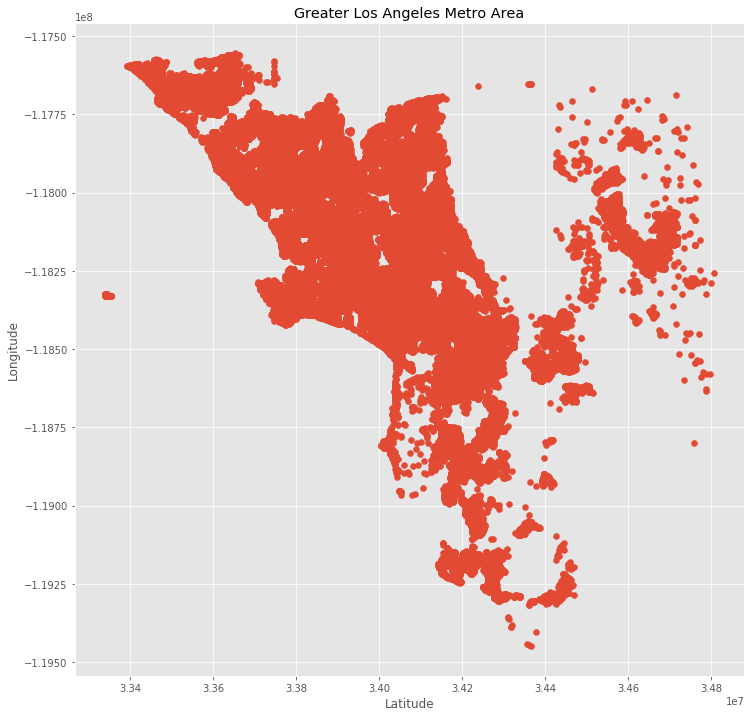

In [13]:
plt.figure(figsize=(12,12))
plt.scatter(x=properties.iloc[0:100000].latitude.values, y=properties.iloc[0:100000].longitude.values)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.title('Greater Los Angeles Metro Area')
plt.show()

#### Adding some features from online kernels


In [15]:


#life of property
properties['N-life'] = 2018 - properties['yearbuilt']

#life of property
properties['N-LivingAreaError'] = properties['cal_fin_sqft']/properties['fin_sqft12']

#proportion of living area
properties['N-LivingAreaProp'] = properties['cal_fin_sqft']/properties['lotsizesquarefeet']
properties['N-LivingAreaProp2'] = properties['fin_sqft12']/properties['fin_sqft15']

#Amout of extra space
properties['N-ExtraSpace'] = properties['lotsizesquarefeet'] - properties['cal_fin_sqft'] 
properties['N-ExtraSpace-2'] = properties['fin_sqft15'] - properties['fin_sqft12'] 

#Total number of rooms
properties['N-TotalRooms'] = properties['bathroomcnt']*properties['bedroomcnt']

#Average room size
properties['N-AvRoomSize'] = properties['cal_fin_sqft']/properties['roomcnt'] 

# Number of Extra rooms
properties['N-ExtraRooms'] = properties['roomcnt'] - properties['N-TotalRooms'] 

#Ratio of the built structure value to land area
properties['N-ValueProp'] = properties['struc_TVDC']/properties['land_TVDC']

#Does property have a garage, pool or hot tub and AC?
properties['N-GarPoolAC'] = ((properties['garagecarcnt']>0) & (properties['pooltypeid10']>0) & (properties['airconditioningtypeid']!=5))*1 

properties["N-location"] = properties["latitude"] + properties["longitude"]
properties["N-location-2"] = properties["latitude"]*properties["longitude"]
properties["N-location-2round"] = properties["N-location-2"].round(-4)

properties["N-latitude-round"] = properties["latitude"].round(-4)
properties["N-longitude-round"] = properties["longitude"].round(-4)

#### Adding some custom features


In [17]:


gbycol = 'rawcensustractandblock'
col1 = 'taxamount'
properties['gby_single_'+gbycol+col1] = properties[gbycol].map(properties.groupby([gbycol])[col1].median().to_dict())


c = 'cal_fin_sqft'
properties[c+'gby_median']= properties.loc[~properties['rawcensustractandblock'].isnull(),['rawcensustractandblock',c]].groupby(['rawcensustractandblock']).transform(lambda x: x/(x.median()))

#Ratio of the built structure value to land area
properties['N-ValueRatio'] = properties['TVDC']/properties['taxamount']

col2 = 'bathroomcnt'
properties['gby_single_'+gbycol+col2] = properties[gbycol].map(properties.groupby([gbycol])[col2].median().to_dict())





In [18]:
properties.columns

Index([u'parcelid', u'airconditioningtypeid', u'architecturalstyletypeid',
       u'basementsqft', u'bathroomcnt', u'bedroomcnt', u'buildingclasstypeid',
       u'buildingqualitytypeid', u'calculatedbathnbr', u'decktypeid',
       u'finishedfloor1squarefeet', u'cal_fin_sqft', u'fin_sqft12',
       u'finishedsquarefeet13', u'fin_sqft15', u'finishedsquarefeet50',
       u'fin_sqft6', u'fips', u'fireplacecnt', u'fullbathcnt', u'garagecarcnt',
       u'garagetotalsqft', u'hashottuborspa', u'heatingorsystemtypeid',
       u'latitude', u'longitude', u'lotsizesquarefeet', u'poolcnt',
       u'poolsizesum', u'pooltypeid10', u'pooltypeid2', u'pooltypeid7',
       u'propertycountylandusecode', u'propertylandusetypeid',
       u'propertyzoningdesc', u'rawcensustractandblock', u'regionidcity',
       u'regionidcounty', u'regionidneighborhood', u'regionidzip', u'roomcnt',
       u'storytypeid', u'threequarterbathnbr', u'typeconstructiontypeid',
       u'unitcnt', u'yardbuildingsqft17', u'yardbuildi

#### LabelEncoding the categorical variables

In [19]:
for c in properties.columns:
    properties[c]=properties[c].fillna(-1)
    if properties[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(properties[c].values))
        properties[c] = lbl.transform(list(properties[c].values))


In [20]:
train_df = train.merge(properties, how='left', on='parcelid')

In [21]:
x_train = train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
x_test = properties.drop(['parcelid'], axis=1)
# shape        
print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))

# drop out ouliers
train_df=train_df[ train_df.logerror > -0.4 ]
train_df=train_df[ train_df.logerror < 0.419 ]
x_train=train_df.drop(['parcelid', 'logerror','transactiondate'], axis=1)
y_train = train_df["logerror"].values.astype(np.float32)
y_mean = np.mean(y_train)

print('After removing outliers:')     
print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))



Shape train: (90275, 77)
Shape test: (2985217, 77)
After removing outliers:
Shape train: (88528, 77)
Shape test: (2985217, 77)


#### Xgboost modeling

In [23]:
# xgboost params
xgb_params = {
    'eta': 0.1,
    'max_depth': 12,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda':0.8,
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1,
    'colsample_bylevel':1.0,
    'min_child_weight':4.0,
    'colsample_bytree':0.5
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

# cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   nfold=5,
                   num_boost_round=3900,
                   early_stopping_rounds=50,
                   verbose_eval=10, 
                   show_stdv=False
                  )
num_boost_rounds = len(cv_result)
print("Number of boosting rounds {}".format(num_boost_rounds))
# train model
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)
pred = model.predict(dtest)



[0]	train-mae:0.0528984	test-mae:0.0531862
[10]	train-mae:0.0497692	test-mae:0.0527224
[20]	train-mae:0.047889	test-mae:0.0527556
[30]	train-mae:0.0463898	test-mae:0.0528858
[40]	train-mae:0.0452448	test-mae:0.0529994
[50]	train-mae:0.0442306	test-mae:0.0531118
[60]	train-mae:0.0431496	test-mae:0.0532092
Number of boosting rounds 16


#### file save and submission

In [26]:
output = pd.DataFrame({'ParcelId': properties['parcelid'].astype(np.int32),
        '201610': pred, '201611': pred, '201612': pred,
        '201710': pred, '201711': pred, '201712': pred})
# set col 'ParceID' to first col
cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]
from datetime import datetime
filename = 'zillow_teja_programming_sample.csv'
#output.to_csv(filename.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

#### checking feature importance.. how important are the custom features are important

In [27]:
import operator
sorted_x = sorted(model.get_fscore().items(), key=operator.itemgetter(1))
sorted_df = pd.DataFrame(sorted_x)
sorted_df.columns = ['feature_name','feature_imp']

In [28]:
sorted_df.tail(10)

,feature_name,feature_imp
55,cal_fin_sqft,554
56,N-location,568
57,N-location-2,591
58,N-ValueRatio,641
59,land_TVDC,656
60,struc_TVDC,673
61,latitude,691
62,lotsizesquarefeet,698
63,TVDC,752
64,cal_fin_sqftgby_median,781


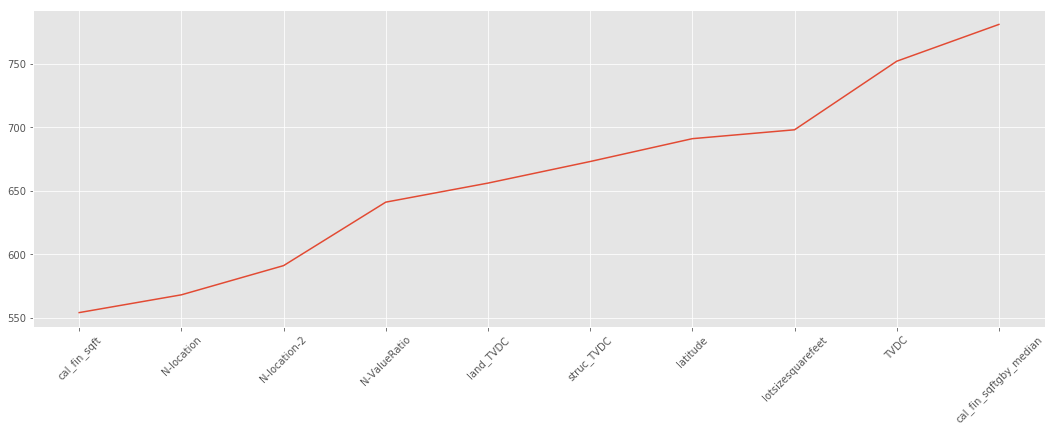

In [29]:
plt.figure(figsize = (15,5))
plt.plot(sorted_df.loc[:,'feature_name'][-10:],sorted_df.loc[:,'feature_imp'][-10:])
plt.style.use('ggplot')
plt.tight_layout()
plt.xticks(rotation = 45)
plt.show()

#### correlation plot of target variable and important features

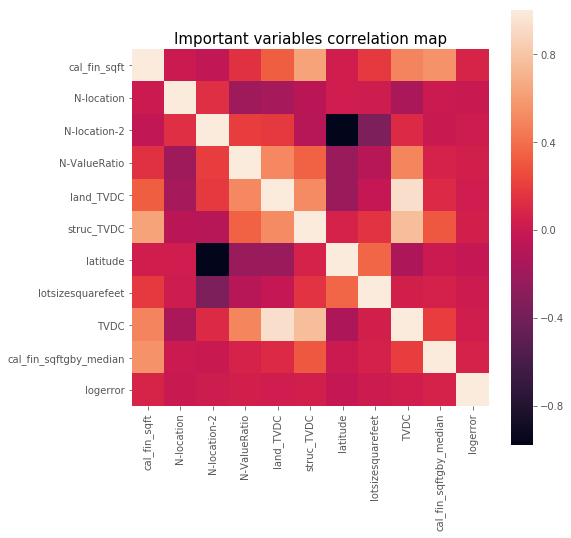

In [30]:
imp_cols = sorted_df.loc[:,'feature_name'][-10:].values
imp_cols = np.append(imp_cols,'logerror')


corrmat = train_df[imp_cols].corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()